# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - simple model

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [11]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1)(x)

model_1 = keras.Model(input, output)

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 50
patience = 2

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/50
58/58 [==============================] - 72s 1s/step - loss: 0.5657 - binary_accuracy: 0.6590 - val_loss: 0.4445 - val_binary_accuracy: 0.7152
Epoch 2/50
58/58 [==============================] - 69s 1s/step - loss: 0.3821 - binary_accuracy: 0.8231 - val_loss: 0.3550 - val_binary_accuracy: 0.8196
Epoch 3/50
58/58 [==============================] - 69s 1s/step - loss: 0.3296 - binary_accuracy: 0.8560 - val_loss: 0.3218 - val_binary_accuracy: 0.8511
Epoch 4/50
58/58 [==============================] - 69s 1s/step - loss: 0.3024 - binary_accuracy: 0.8731 - val_loss: 0.3004 - val_binary_accuracy: 0.8707
Epoch 5/50
58/58 [==============================] - 69s 1s/step - loss: 0.2834 - binary_accuracy: 0.8821 - val_loss: 0.2893 - val_binary_accuracy: 0.8761
Epoch 6/50
58/58 [==============================] - 69s 1s/step - loss: 0.2706 - binary_accuracy: 0.8921 - val_loss: 0.2757 - val_binary_accuracy: 0.8880
Epoch 7/50
58/58 [==============================] - 70s 1s/step - loss: 0.25

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

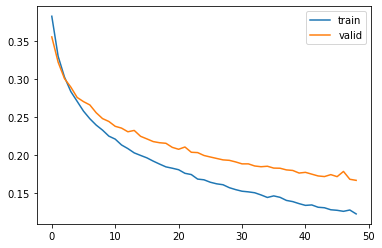

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

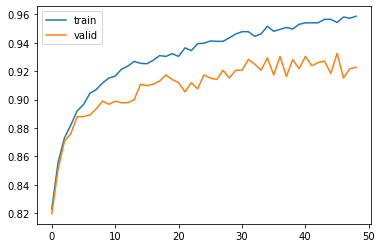

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.9375

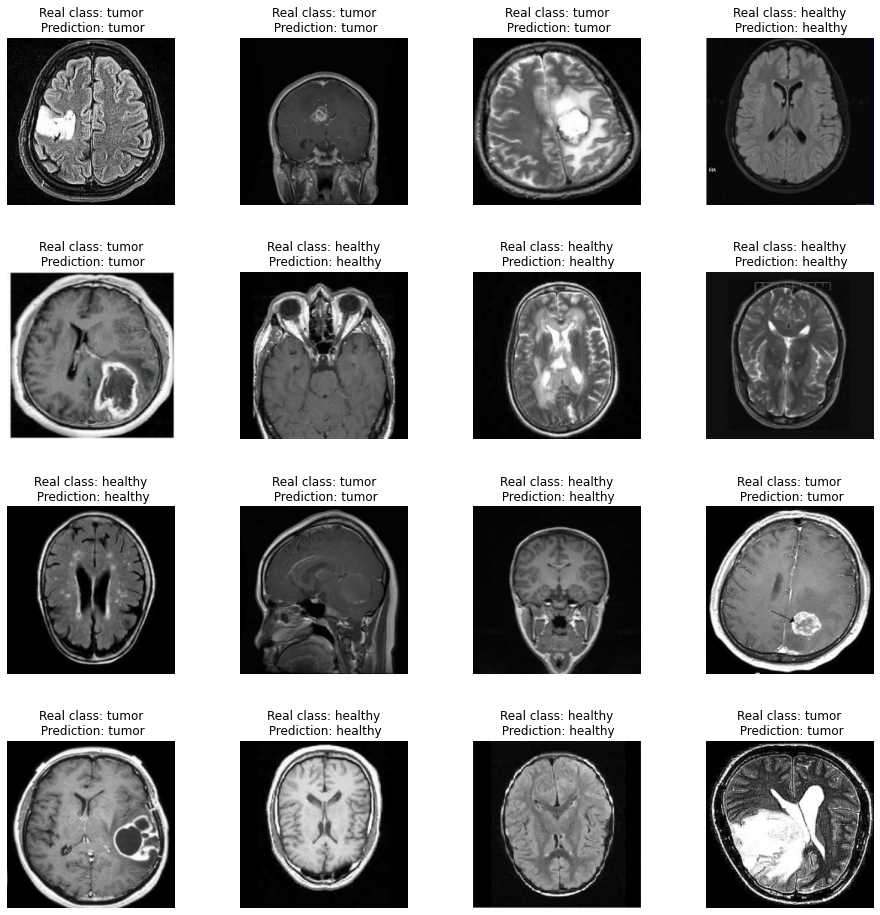

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

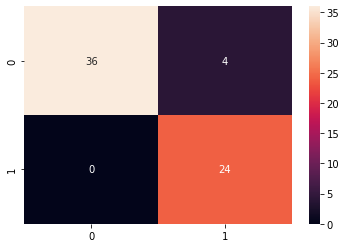

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.86      1.00      0.92        24

    accuracy                           0.94        64
   macro avg       0.93      0.95      0.94        64
weighted avg       0.95      0.94      0.94        64



## Mobilenet_v2 - model with data augmentation

In [23]:
input_shape = (224, 224, 3)

In [24]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.mobilenet_v2.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1)(x)

model_2 = keras.Model(input, output)

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0   

In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 50
patience = 2

In [27]:
history_2 = model_2.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/50
58/58 [==============================] - 76s 1s/step - loss: 0.5039 - binary_accuracy: 0.7342 - val_loss: 0.3590 - val_binary_accuracy: 0.8217
Epoch 2/50
58/58 [==============================] - 73s 1s/step - loss: 0.3412 - binary_accuracy: 0.8476 - val_loss: 0.2831 - val_binary_accuracy: 0.8902
Epoch 3/50
58/58 [==============================] - 73s 1s/step - loss: 0.2829 - binary_accuracy: 0.8823 - val_loss: 0.2474 - val_binary_accuracy: 0.8957
Epoch 4/50
58/58 [==============================] - 73s 1s/step - loss: 0.2521 - binary_accuracy: 0.9041 - val_loss: 0.2236 - val_binary_accuracy: 0.9109
Epoch 5/50
58/58 [==============================] - 73s 1s/step - loss: 0.2326 - binary_accuracy: 0.9141 - val_loss: 0.2074 - val_binary_accuracy: 0.9228
Epoch 6/50
58/58 [==============================] - 74s 1s/step - loss: 0.2100 - binary_accuracy: 0.9212 - val_loss: 0.2033 - val_binary_accuracy: 0.9076
Epoch 7/50
58/58 [==============================] - 73s 1s/step - loss: 0.20

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

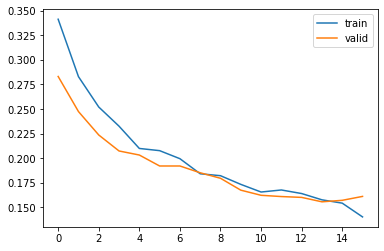

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

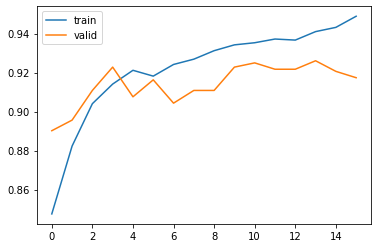

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.96875

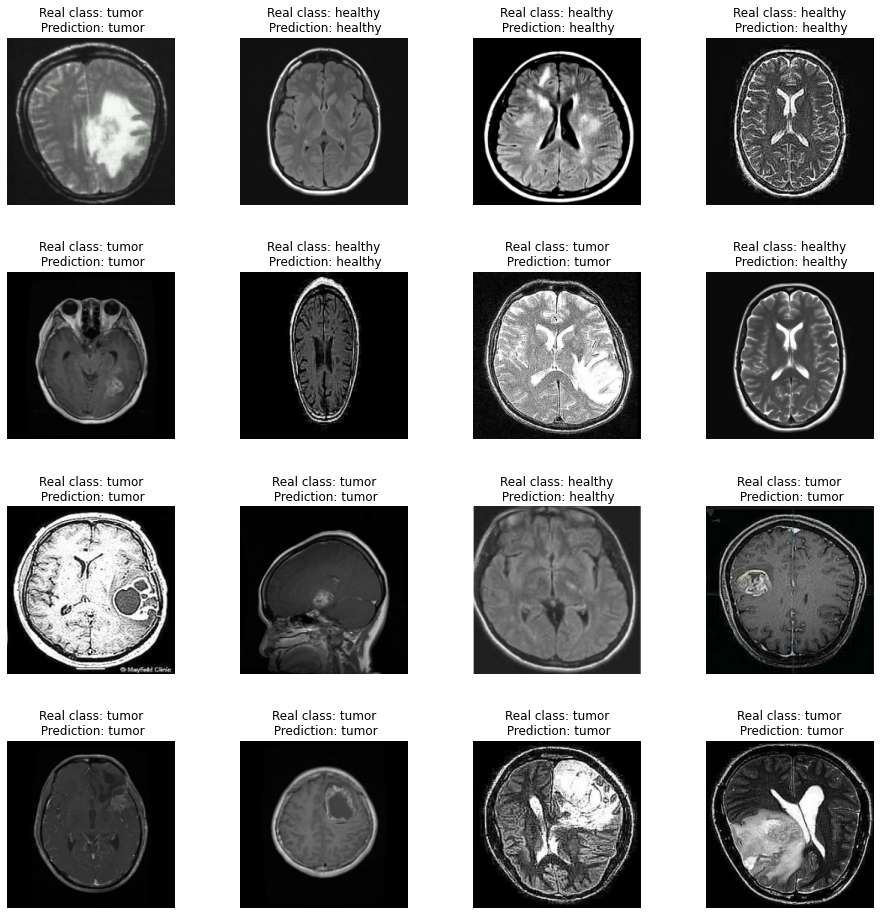

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

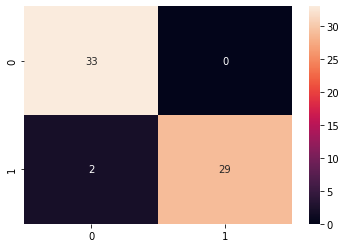

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.94      0.97        31

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



## Mobilenet_v2 - model with data augmentation + additional layers

In [36]:
input_shape = (224, 224, 3)

In [37]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.mobilenet_v2.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_3 = keras.Model(input, output)

model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0   

In [38]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [39]:
epochs = 50
patience = 5

In [40]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/50
58/58 [==============================] - 76s 1s/step - loss: 0.4234 - binary_accuracy: 0.8342 - val_loss: 0.2113 - val_binary_accuracy: 0.9163
Epoch 2/50
58/58 [==============================] - 74s 1s/step - loss: 0.1961 - binary_accuracy: 0.9204 - val_loss: 0.1493 - val_binary_accuracy: 0.9370
Epoch 3/50
58/58 [==============================] - 74s 1s/step - loss: 0.2099 - binary_accuracy: 0.9136 - val_loss: 0.1556 - val_binary_accuracy: 0.9293
Epoch 4/50
58/58 [==============================] - 73s 1s/step - loss: 0.1806 - binary_accuracy: 0.9274 - val_loss: 0.2010 - val_binary_accuracy: 0.9087
Epoch 5/50
58/58 [==============================] - 74s 1s/step - loss: 0.1484 - binary_accuracy: 0.9427 - val_loss: 0.1276 - val_binary_accuracy: 0.9478
Epoch 6/50
58/58 [==============================] - 74s 1s/step - loss: 0.1773 - binary_accuracy: 0.9302 - val_loss: 0.3004 - val_binary_accuracy: 0.8652
Epoch 7/50
58/58 [==============================] - 74s 1s/step - loss: 0.14

In [41]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

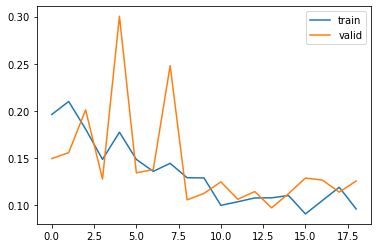

In [42]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

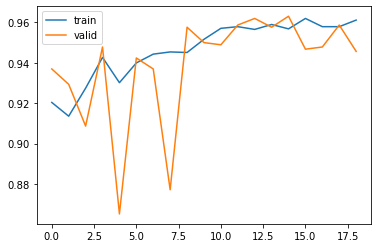

In [43]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [44]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.953125

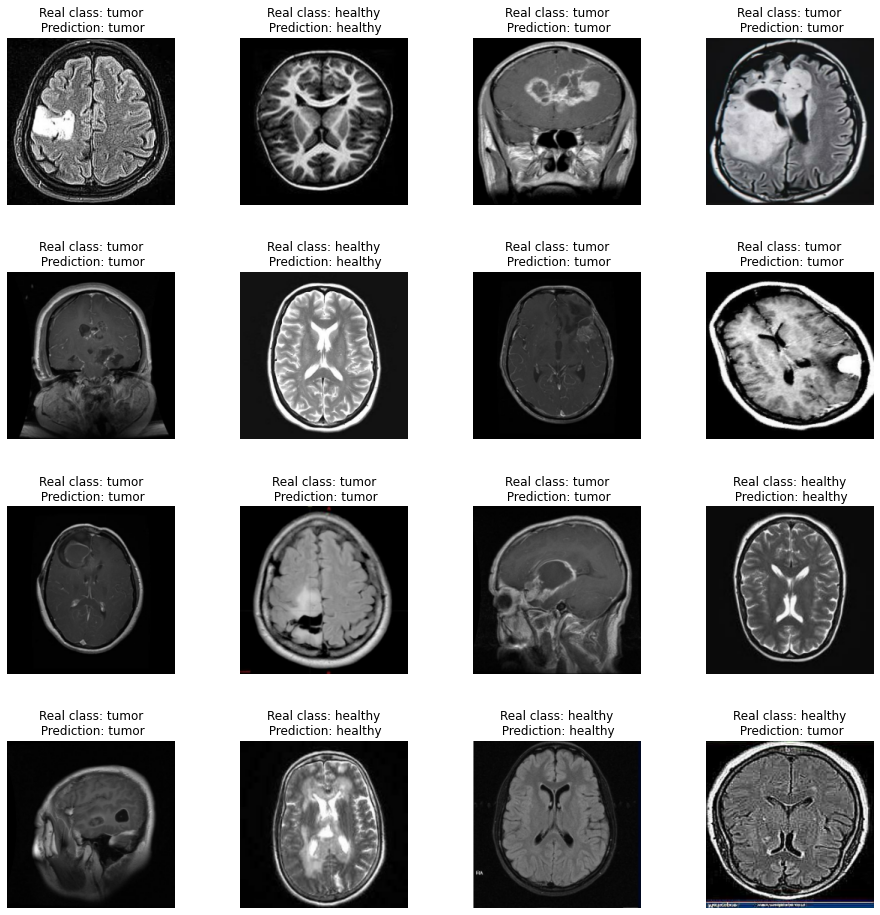

In [45]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [46]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

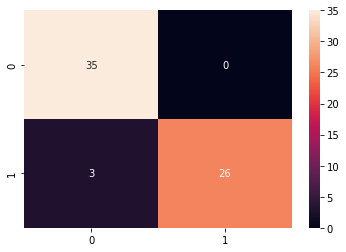

In [47]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [48]:
print(classification_report(y_val_3, y_pred_3_binary))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.90      0.95        29

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64



## Inception_v3 - simple model

In [49]:
input_shape = (256, 256, 3)

In [50]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
output = keras.layers.Dense(1)(x)

model_4 = keras.Model(input, output)

model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [51]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [52]:
epochs = 50
patience = 5

In [53]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/50
58/58 [==============================] - 183s 3s/step - loss: 1.7191 - binary_accuracy: 0.5908 - val_loss: 0.9002 - val_binary_accuracy: 0.6772
Epoch 2/50
58/58 [==============================] - 179s 3s/step - loss: 0.9364 - binary_accuracy: 0.6981 - val_loss: 0.8828 - val_binary_accuracy: 0.7065
Epoch 3/50
58/58 [==============================] - 180s 3s/step - loss: 0.7538 - binary_accuracy: 0.7457 - val_loss: 1.0389 - val_binary_accuracy: 0.6783
Epoch 4/50
58/58 [==============================] - 180s 3s/step - loss: 0.6365 - binary_accuracy: 0.7785 - val_loss: 0.4644 - val_binary_accuracy: 0.8217
Epoch 5/50
58/58 [==============================] - 180s 3s/step - loss: 0.5274 - binary_accuracy: 0.7943 - val_loss: 0.4504 - val_binary_accuracy: 0.8337
Epoch 6/50
58/58 [==============================] - 180s 3s/step - loss: 0.4759 - binary_accuracy: 0.8120 - val_loss: 0.7940 - val_binary_accuracy: 0.7457
Epoch 7/50
58/58 [==============================] - 180s 3s/step - los

In [54]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

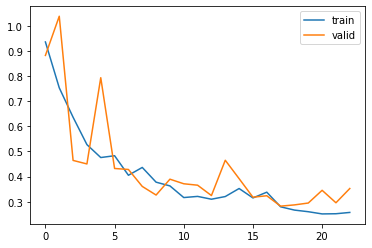

In [55]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

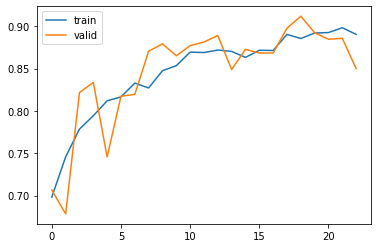

In [56]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [57]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.875

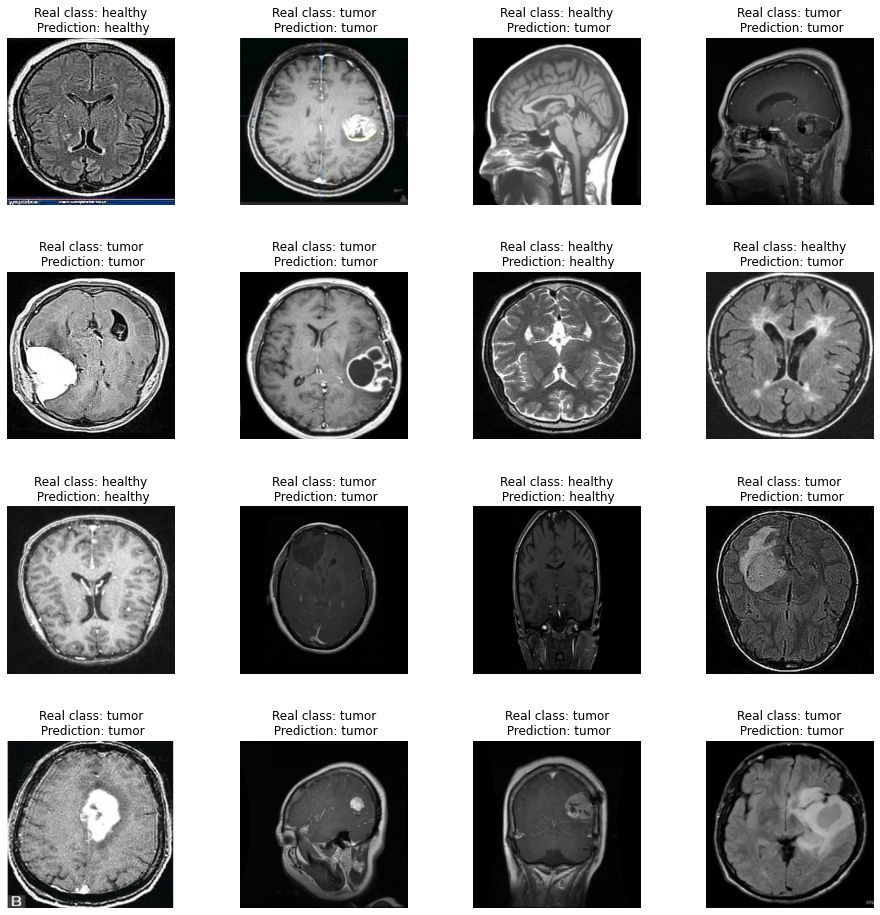

In [58]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [59]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

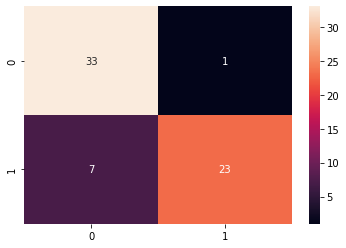

In [60]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [61]:
print(classification_report(y_val_4, y_pred_4_binary))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        34
           1       0.96      0.77      0.85        30

    accuracy                           0.88        64
   macro avg       0.89      0.87      0.87        64
weighted avg       0.89      0.88      0.87        64



## Inception_v3 model - with data augmentation

In [62]:
input_shape = (256, 256, 3)

In [63]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.inception_v3.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(x, training=False)
output = keras.layers.Dense(1)(x)

model_5 = keras.Model(input, output)

model_5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_2 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049

In [64]:
model_5.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [65]:
epochs = 50
patience = 5

In [66]:
history_5 = model_5.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/50
58/58 [==============================] - 189s 3s/step - loss: 0.4985 - binary_accuracy: 0.7277 - val_loss: 0.4057 - val_binary_accuracy: 0.8054
Epoch 2/50
58/58 [==============================] - 186s 3s/step - loss: 0.3672 - binary_accuracy: 0.8332 - val_loss: 0.3830 - val_binary_accuracy: 0.8478
Epoch 3/50
58/58 [==============================] - 186s 3s/step - loss: 0.3315 - binary_accuracy: 0.8617 - val_loss: 0.3386 - val_binary_accuracy: 0.8630
Epoch 4/50
58/58 [==============================] - 187s 3s/step - loss: 0.3041 - binary_accuracy: 0.8693 - val_loss: 0.3184 - val_binary_accuracy: 0.8761
Epoch 5/50
58/58 [==============================] - 187s 3s/step - loss: 0.2825 - binary_accuracy: 0.8753 - val_loss: 0.2967 - val_binary_accuracy: 0.8761
Epoch 6/50
58/58 [==============================] - 187s 3s/step - loss: 0.2723 - binary_accuracy: 0.8883 - val_loss: 0.3108 - val_binary_accuracy: 0.8870
Epoch 7/50
58/58 [==============================] - 186s 3s/step - los

In [67]:
history_5.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

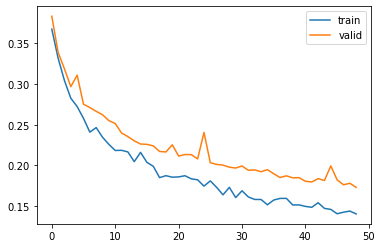

In [68]:
plt.plot(history_5.history['loss'][1:])
plt.plot(history_5.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

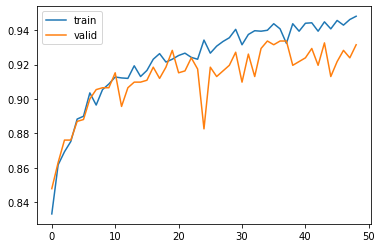

In [69]:
plt.plot(history_5.history['binary_accuracy'][1:])
plt.plot(history_5.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [70]:
x_val_5, y_val_5 = list(tfds.as_numpy(ds_val))[0]
y_pred_5 = model_5.predict(x_val_5)
sum((y_pred_5[:, 0] > 0) == y_val_5) / len(y_val_5)

0.875

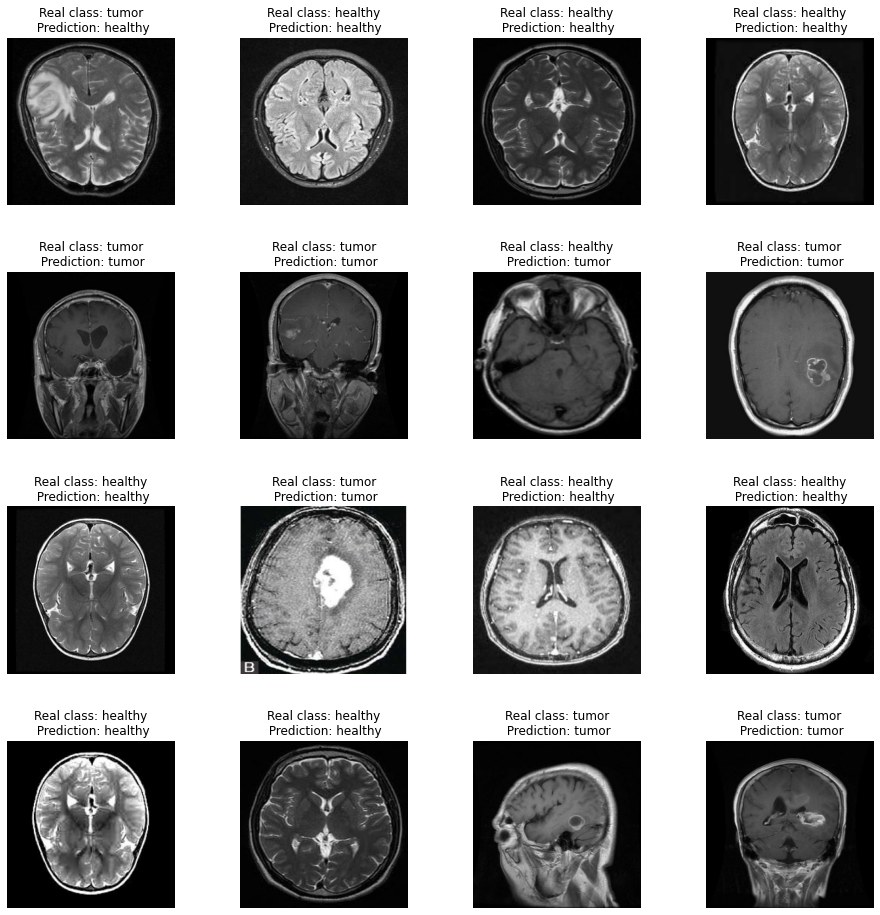

In [71]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_5[i].astype('int32'))
    
    real_y = 'healthy' if y_val_5[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_5[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [72]:
y_pred_5_binary = [1 if y > 0 else 0 for y in y_pred_5]

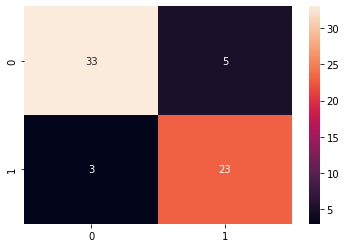

In [73]:
cf = tf.math.confusion_matrix(y_val_5, y_pred_5_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [74]:
print(classification_report(y_val_5, y_pred_5_binary))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89        38
           1       0.82      0.88      0.85        26

    accuracy                           0.88        64
   macro avg       0.87      0.88      0.87        64
weighted avg       0.88      0.88      0.88        64



## Inception_v3 - model with data augmentation + additional layers

In [14]:
input_shape = (256, 256, 3)

In [15]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.inception_v3.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_6 = keras.Model(input, output)

model_6.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5245

In [16]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [17]:
epochs = 50
patience = 5

In [18]:
history_6 = model_6.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/50
58/58 [==============================] - 540s 9s/step - loss: 1.1113 - binary_accuracy: 0.7152 - val_loss: 0.5100 - val_binary_accuracy: 0.8239
Epoch 2/50
58/58 [==============================] - 511s 9s/step - loss: 0.3042 - binary_accuracy: 0.8682 - val_loss: 0.2743 - val_binary_accuracy: 0.8717
Epoch 3/50
58/58 [==============================] - 524s 9s/step - loss: 0.2539 - binary_accuracy: 0.8902 - val_loss: 0.2628 - val_binary_accuracy: 0.9109
Epoch 4/50
58/58 [==============================] - 525s 9s/step - loss: 0.2235 - binary_accuracy: 0.9073 - val_loss: 0.2324 - val_binary_accuracy: 0.8978
Epoch 5/50
58/58 [==============================] - 599s 10s/step - loss: 0.2255 - binary_accuracy: 0.9095 - val_loss: 0.3044 - val_binary_accuracy: 0.8859
Epoch 6/50
58/58 [==============================] - 613s 11s/step - loss: 0.3206 - binary_accuracy: 0.8685 - val_loss: 0.2882 - val_binary_accuracy: 0.9011
Epoch 7/50
58/58 [==============================] - 611s 11s/step - 

In [19]:
history_6.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

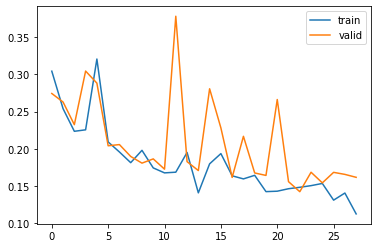

In [20]:
plt.plot(history_6.history['loss'][1:])
plt.plot(history_6.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

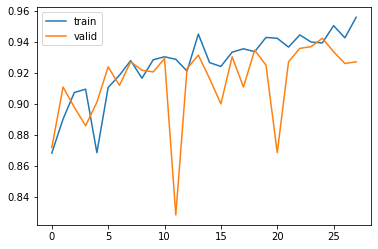

In [21]:
plt.plot(history_6.history['binary_accuracy'][1:])
plt.plot(history_6.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [22]:
x_val_6, y_val_6 = list(tfds.as_numpy(ds_val))[0]
y_pred_6 = model_6.predict(x_val_6)
sum((y_pred_6[:, 0] > 0) == y_val_6) / len(y_val_6)

0.953125

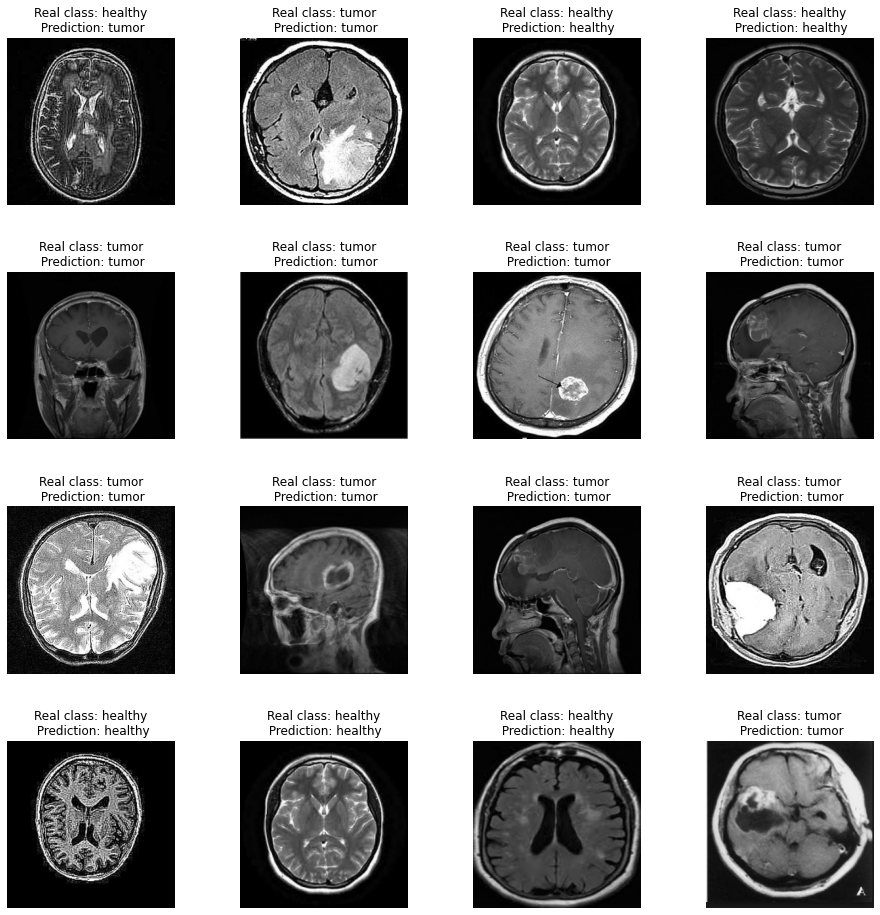

In [23]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_6[i].astype('int32'))
    
    real_y = 'healthy' if y_val_6[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_6[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [24]:
y_pred_6_binary = [1 if y > 0 else 0 for y in y_pred_6]

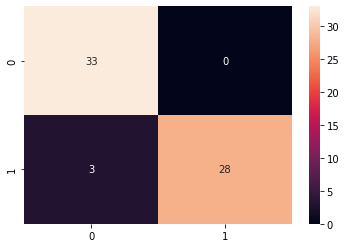

In [25]:
cf = tf.math.confusion_matrix(y_val_6, y_pred_6_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [26]:
print(classification_report(y_val_6, y_pred_6_binary))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.90      0.95        31

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64

